In [2]:
%cd /Users/rattie/Dev/sdo_tracking_framework
import os, glob
import numpy as np
import fitsio
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import balltracking.balltrack as blt
%matplotlib notebook

/Users/rattie/Dev/sdo_tracking_framework


In [3]:
def load_vel_mean(v_files, trange):
    "Load vx, vy velocity component from fits files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy

def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def load_bt_vel(vel_dir, fwhm, kernel):
    "Load the balltracked velocity. Already time averaged"
    vx_top = fitsio.read(os.path.join(vel_dir, 'vxtop_fwhm{:d}_kernel_{:s}.fits'.format(fwhm, kernel)))
    vy_top = fitsio.read(os.path.join(vel_dir, 'vytop_fwhm{:d}_kernel_{:s}.fits'.format(fwhm, kernel)))
    vx_bottom = fitsio.read(os.path.join(vel_dir, 'vxbottom_fwhm{:d}_kernel_{:s}.fits'.format(fwhm, kernel)))
    vy_bottom = fitsio.read(os.path.join(vel_dir, 'vybottom_fwhm{:d}_kernel_{:s}.fits'.format(fwhm, kernel)))
    return vx_top, vy_top, vx_bottom, vy_bottom


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


In [14]:
# parent directory of the balltrack velocity directories and simulation 
bt_dir = '/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/'
stein_dir = '/Users/rattie/Data/Ben/SteinSDO/'
### Ball parameters
# Use 80 frames (1 hr)
nframes = 80
trange = [0, nframes]

# Ball radius
rs = 2
# Get series of all other input parameters
dp_l = [0.1, 0.2, 0.3, 0.4, 0.5]
sigma_factor_l = [1, 1.25, 1.5, 1.75, 2]
intsteps_l = [3, 4, 5]
# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]
# Smoothing kernel 
kernel = 'boxcar'
fwhm = 7

### Load Stein simulation data

In [15]:
svx_files = sorted(glob.glob(os.path.join(stein_dir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(stein_dir,'SDO_vy*.fits')))
# Load Stein velocities
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)
# smooth the Stein velocities 
vx_stein1, vy_stein1 = smooth_vel(vx_stein, vy_stein, fwhm, kernel=kernel) 

In [16]:
# Correlation matrix, load balltrack velocity on the fly
c_top = np.empty([len(sigma_factor_l), len(dp_l), len(intsteps_l)])
c_bottom = np.empty(c_top.shape)

for i, dp in enumerate(dp_l):
    for j, sigmaf in enumerate(sigma_factor_l):
        for k,intsteps in enumerate(intsteps_l):
            vel_dir = os.path.join(bt_dir, 
                           'rs{:0.1f}_dp{:0.1f}_sigmaf{:0.2f}_intsteps{:d}_nt{:d}'.format(rs, dp, sigmaf, intsteps, nframes))
            vx_top, vy_top, vx_bottom, vy_bottom = load_bt_vel(vel_dir, fwhm, kernel)
            c_top[i, j, k] = calc_c_pearson(vx_stein1, vx_top, vy_stein1, vy_top, fov=fov)
            c_bottom[i, j, k] = calc_c_pearson(vx_stein1, vx_bottom, vy_stein1, vy_bottom, fov=fov)
            

### Plot results for each intsteps value

<IPython.core.display.Javascript object>


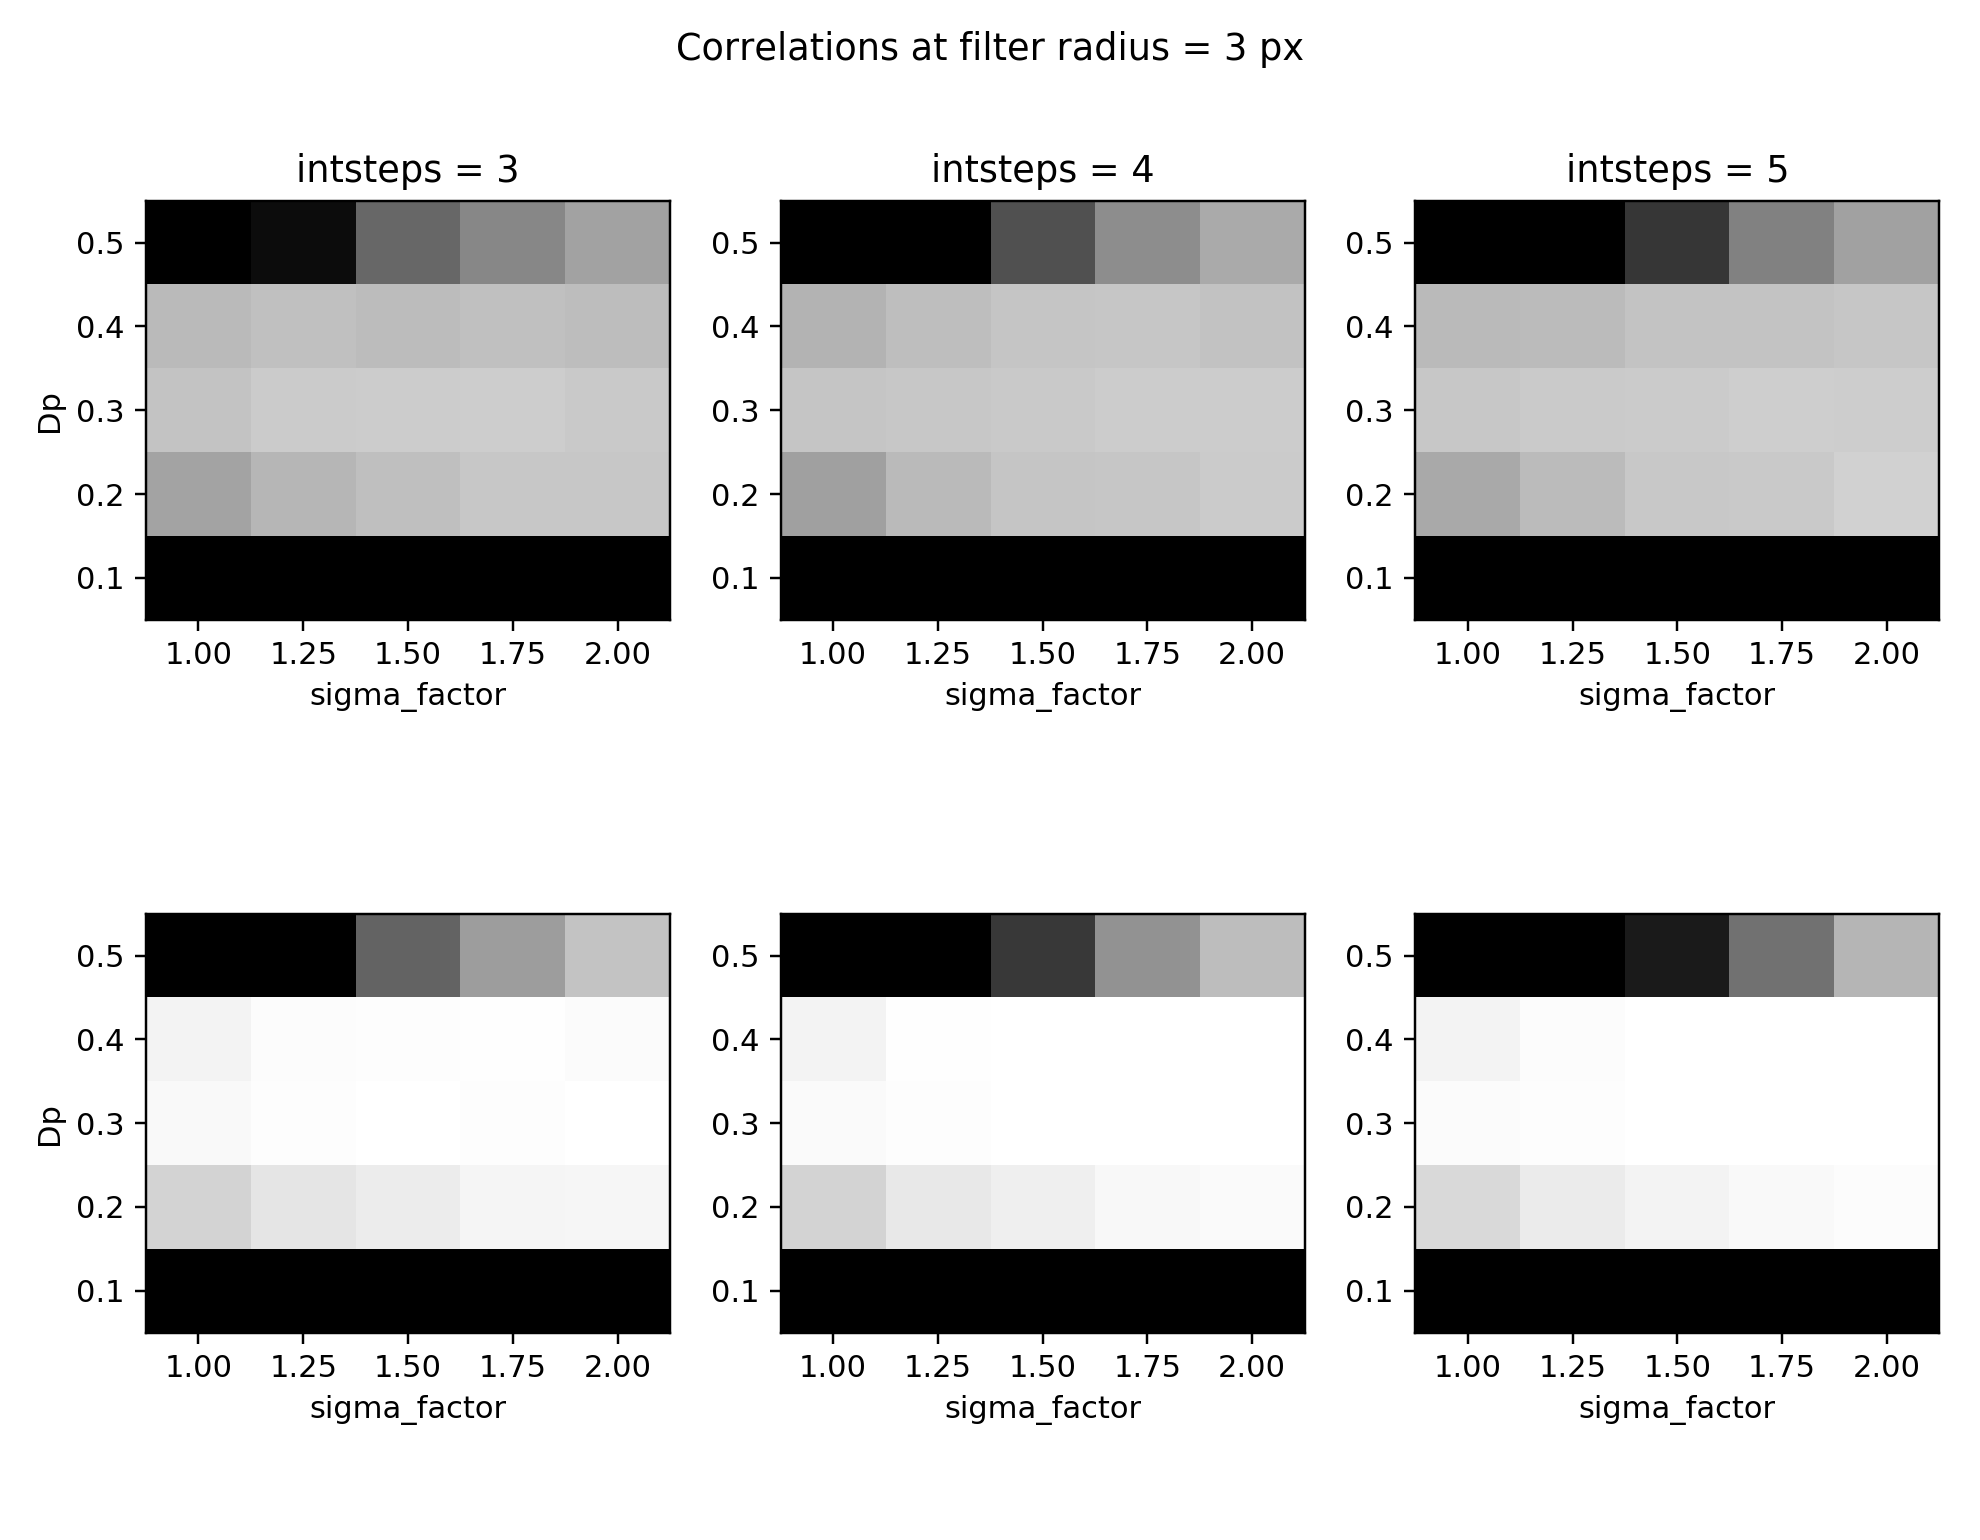

In [32]:
%matplotlib notebook
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 7))
aspect=2
extent = [sigma_factor_l[0]-0.25/2, sigma_factor_l[-1]+0.25/2, dp_l[0]-0.05, dp_l[-1]+0.05]
vmin, vmax = 0.8, 0.92
ims = []
for i,intsteps in enumerate(intsteps_l):
    im = axs[0,i].imshow(c_top[:,:,i], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap='gray', aspect=aspect)
    axs[0,i].set_xlabel('sigma_factor')
    axs[0,i].set_title('intsteps = {:d}'.format(intsteps))

    axs[1,i].imshow(c_bottom[:,:,i], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap='gray', aspect=aspect)
    axs[1,i].set_xlabel('sigma_factor')
    ims.append(im)
    

axs[0,0].set_ylabel('Dp')
axs[1,0].set_ylabel('Dp')
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(ims[0], cax=cax, orientation='horizontal')
plt.suptitle('Correlations at filter radius = 3 px')

plt.tight_layout()

plt.savefig(os.path.join(bt_dir,'correlations_matrix_fourier_3px.png'))

### Look at the dependence on Fourier filter radius

In [25]:
def get_correlations(kernel, fourier_radii, a_tops, a_bottoms):
    # Fourier filter radius, load balltrack velocity on the fly
    a_tops = cal_factors[0,:]
    a_bottoms = cal_factors[1,:]
    
    # calculate correlation matrix
    cor_top = []
    cor_bottom = []
    cor_avg = []
    
    vx_stein_smooth, vy_stein_smooth = smooth_vel(vx_stein, vy_stein, fwhm, kernel=kernel) 

    for i, radius in enumerate(f_radius_l):
        vel_dir = os.path.join(bt_dir, 'filter_radius{:d}'.format(radius))
        vx_top, vy_top, vx_bottom, vy_bottom = load_bt_vel(vel_dir, fwhm, kernel)
        # Derive average velocity using calibration factors
        vx_avg = (a_tops[i] * vx_top + a_bottoms[i]*vx_bottom)/2
        vy_avg = (a_tops[i] * vy_top + a_bottoms[i]*vy_bottom)/2 

        cor_top.append(calc_c_pearson(vx_stein_smooth, vx_top, vy_stein_smooth, vy_top, fov=fov))
        cor_bottom.append(calc_c_pearson(vx_stein_smooth, vx_bottom, vy_stein_smooth, vy_bottom, fov=fov))
        cor_avg.append(calc_c_pearson(vx_stein_smooth, vx_avg, vy_stein_smooth, vy_avg, fov=fov))
        
    return cor_top, cor_bottom, cor_avg

In [26]:
sigma_factor = 1.50
bt_dir = '/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/sigma_factor_{:1.2f}'.format(sigma_factor)
# Fourier filter radius, load balltrack velocity on the fly
f_radius_l = np.arange(0, 21)
# Load the linear calibration factors that map to the filter radius
cal_factors = np.load('/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/cal_factors_sigma_factor{:1.2f}_{:s}.npy'.format(sigma_factor, kernel))
a_tops = cal_factors[0,:]
a_bottoms = cal_factors[1,:]

<IPython.core.display.Javascript object>


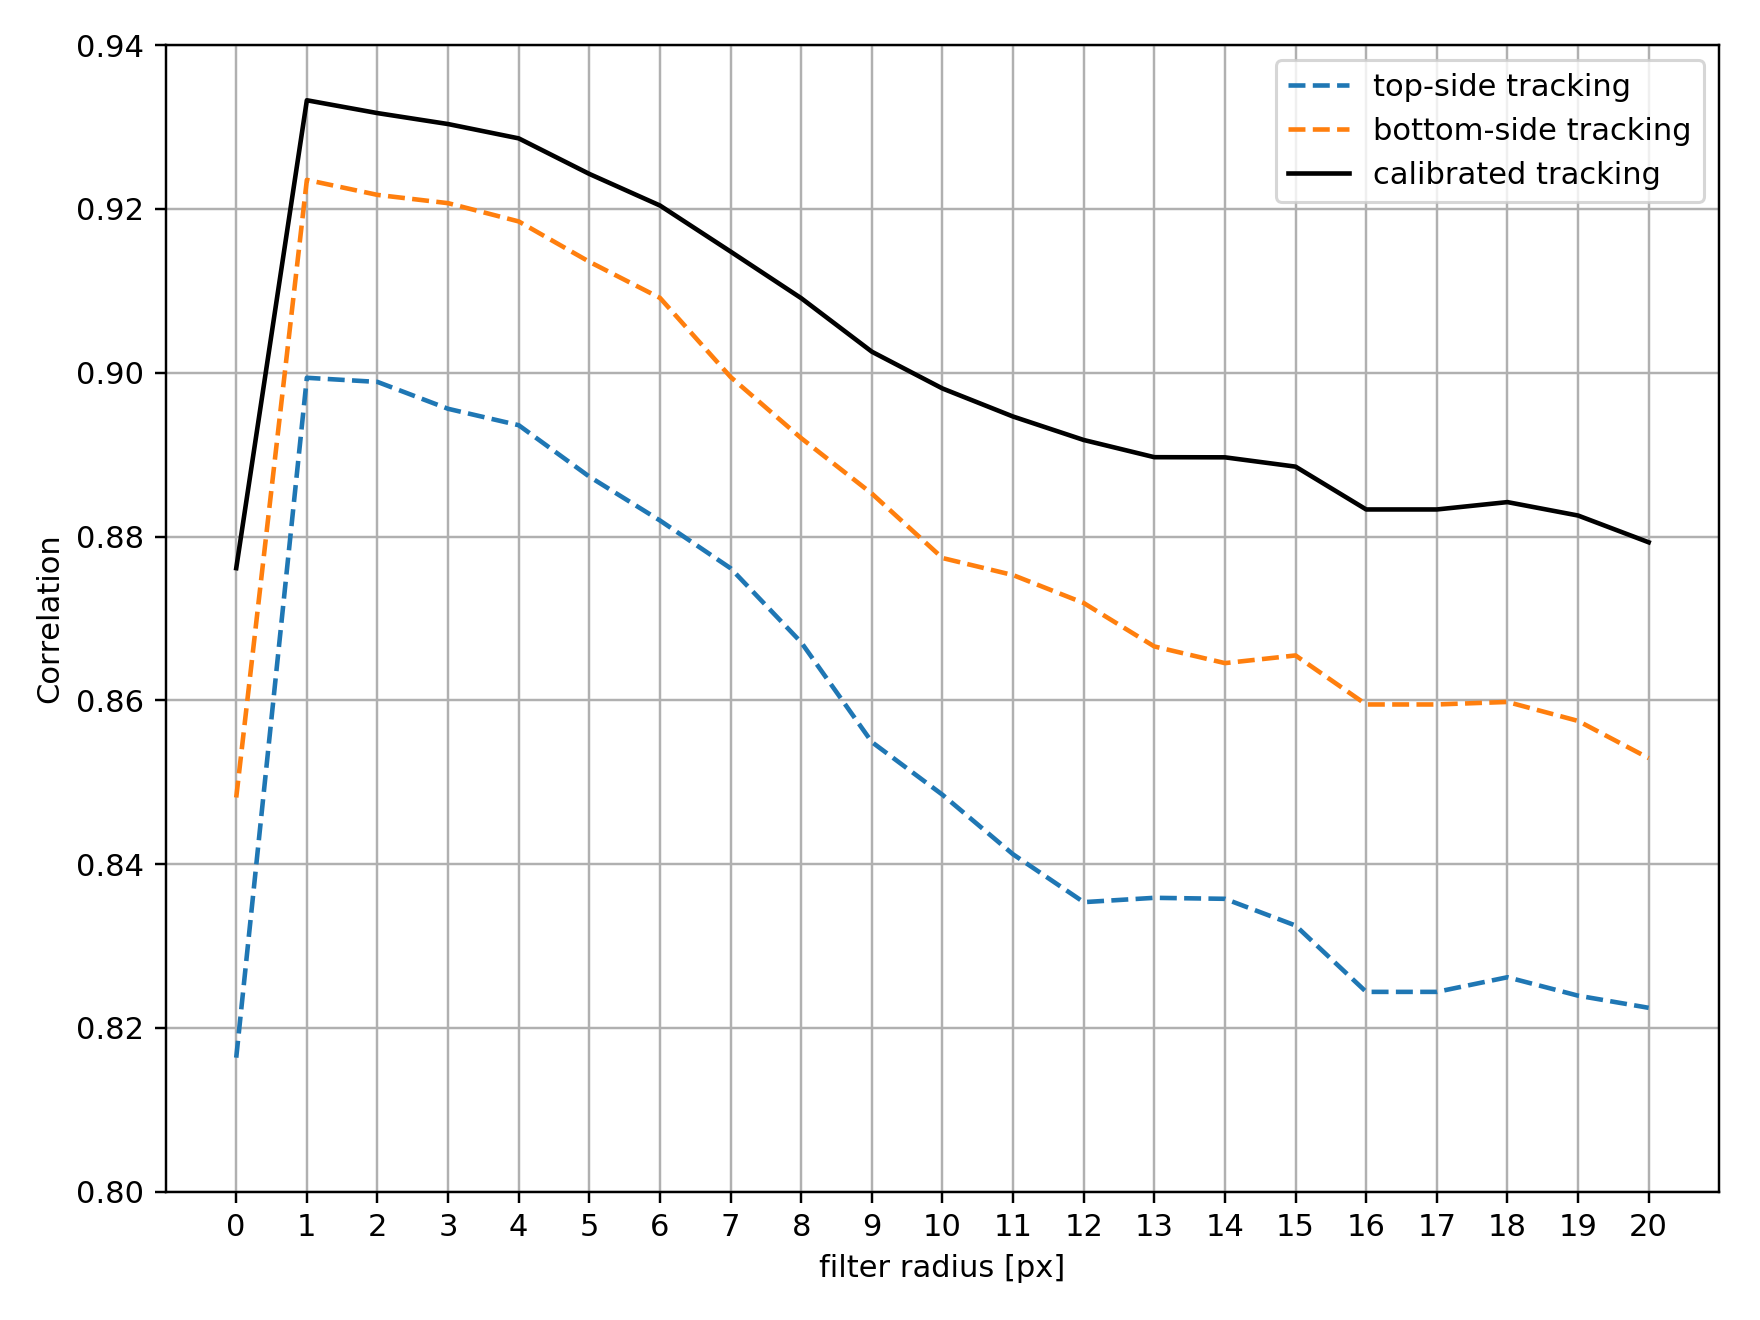

In [36]:
# smooth the Stein velocities 
kernel='boxcar'
c_top2, c_bottom2, c_avg2 = get_correlations(kernel, f_radius_l, a_tops, a_bottoms)

plt.figure(figsize=(8,6))
plt.plot(f_radius_l, c_top2, ls='--', label='top-side tracking')
plt.plot(f_radius_l, c_bottom2, ls='--', label='bottom-side tracking')
plt.plot(f_radius_l, c_avg2, color='black', label='calibrated tracking')
plt.xlabel('filter radius [px]')
plt.ylabel('Correlation')
plt.ylim([0.8, 0.94])
plt.gca().set_xticks(f_radius_l)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/correlations_fourier_radii_sigma_factor_{:1.2f}.png'.format(sigma_factor))